In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
internet = ['AMZN','BABA','MELI','EBAY','NFLX','FB','TWTR','DIS','GOOGL']

In [3]:
df = yahoo.download(internet,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  9 of 9 completed


MELI     1.894342
AMZN     1.770519
NFLX     1.632344
BABA     1.523484
FB       1.436174
EBAY     1.413715
GOOGL    1.286293
DIS      0.976734
TWTR     0.935587
dtype: float64

In [4]:
df

,AMZN,BABA,DIS,EBAY,FB,GOOGL,MELI,NFLX,TWTR
Datetime,,,,,,,,,
2019-08-15 09:30:00-04:00,1778.010010,166.710007,133.669998,39.810001,181.899994,1167.805054,612.349976,295.630005,40.520000
2019-08-15 10:30:00-04:00,1771.979980,166.210007,133.574005,39.439999,181.846893,1170.130005,607.500000,292.487793,40.419998
2019-08-15 11:30:00-04:00,1775.979980,165.050003,133.550003,39.404999,181.970001,1170.859985,608.710022,293.454010,40.290001
2019-08-15 12:30:00-04:00,1774.160034,165.690002,133.330002,39.380001,181.440002,1168.140015,611.604492,292.979889,40.230000
2019-08-15 13:30:00-04:00,1771.206055,165.335007,133.250000,39.345001,181.300003,1170.199951,608.446472,293.394989,40.000099
...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,3147.969971,252.440002,130.520004,56.419998,259.609985,1512.140015,1158.989990,482.209991,37.540001
2020-08-14 12:30:00-04:00,3150.000000,253.395004,130.321198,56.415001,261.269989,1511.574951,1164.015015,482.529999,37.840000
2020-08-14 13:30:00-04:00,3141.219971,252.789993,130.389999,56.260101,261.079987,1508.290039,1160.035034,481.575012,37.820000


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = len(df.index)
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

NFLX     0.150
MELI     0.147
AMZN     0.145
EBAY     0.137
BABA     0.136
FB       0.112
GOOGL    0.098
DIS      0.044
TWTR     0.031
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


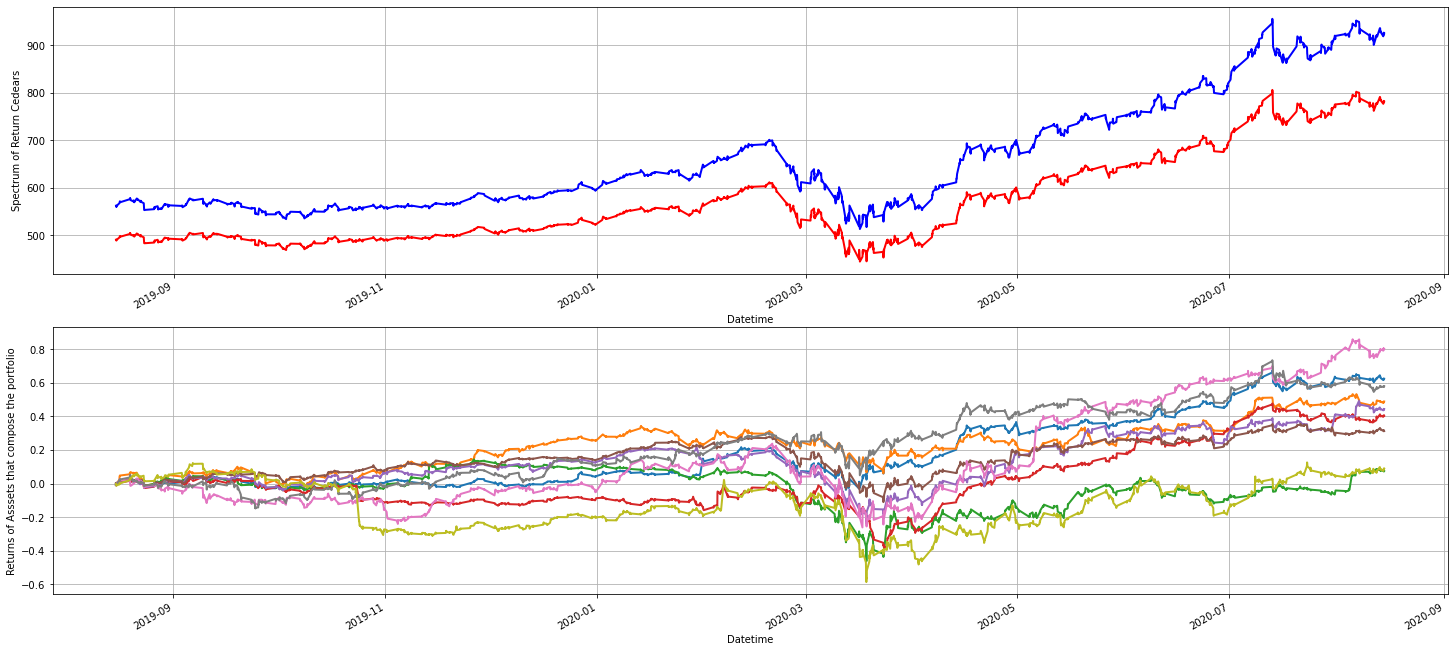

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-15 09:30:00-04:00    562.253224
 2019-08-15 10:30:00-04:00    560.290476
 2019-08-15 11:30:00-04:00    561.110966
 2019-08-15 12:30:00-04:00    560.947601
 2019-08-15 13:30:00-04:00    560.239782
                                 ...    
 2020-08-14 11:30:00-04:00    925.392713
 2020-08-14 12:30:00-04:00    926.734039
 2020-08-14 13:30:00-04:00    924.288333
 2020-08-14 14:30:00-04:00    922.462943
 2020-08-14 15:30:00-04:00    925.005591
 Length: 1765, dtype: float64,
 Datetime
 2019-08-15 09:30:00-04:00    490.711672
 2019-08-15 10:30:00-04:00    489.287631
 2019-08-15 11:30:00-04:00    489.918778
 2019-08-15 12:30:00-04:00    489.661604
 2019-08-15 13:30:00-04:00    489.164175
                                 ...    
 2020-08-14 11:30:00-04:00    781.982218
 2020-08-14 12:30:00-04:00    783.040128
 2020-08-14 13:30:00-04:00    781.051126
 2020-08-14 14:30:00-04:00    779.601365
 2020-08-14 15:30:00-04:00    781.408889
 Length: 1765, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

NFLX     0.15
MELI     0.15
EBAY     0.14
BABA     0.14
AMZN     0.14
FB       0.11
GOOGL    0.10
DIS      0.04
TWTR     0.03
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-15 09:30:00-04:00    557.383104
2019-08-15 10:30:00-04:00    555.438086
2019-08-15 11:30:00-04:00    556.238901
2019-08-15 12:30:00-04:00    556.092364
2019-08-15 13:30:00-04:00    555.393266
                                ...    
2020-08-14 11:30:00-04:00    916.254293
2020-08-14 12:30:00-04:00    917.600395
2020-08-14 13:30:00-04:00    915.177318
2020-08-14 14:30:00-04:00    913.367006
2020-08-14 15:30:00-04:00    915.852001
Length: 1765, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AMZN,0.111111,0.579372,0.007731,0.013437,0.148924
BABA,0.111111,0.568694,0.008743,0.014916,0.148924
DIS,0.111111,0.528472,0.010552,0.016730,0.148924
EBAY,0.111111,0.499428,0.008040,0.012046,0.148924
FB,0.111111,0.605164,0.009578,0.017388,0.148924
GOOGL,0.111111,0.637567,0.008265,0.015808,0.148924
MELI,0.111111,0.549854,0.013658,0.022530,0.148924
NFLX,0.111111,0.500297,0.010039,0.015068,0.148924
TWTR,0.111111,0.529329,0.013225,0.021001,0.148924


In [15]:
poe, fullstress

(AMZN     -7.566539
 BABA     -7.829029
 DIS      -8.245430
 EBAY    -10.306473
 FB      -11.994141
 GOOGL   -11.081777
 MELI     -9.134117
 NFLX     -7.782150
 TWTR    -14.063565
 dtype: float64,
 -1.4826821311025309)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-15 09:30:00-04:00    490.711672
2019-08-15 10:30:00-04:00    489.287631
2019-08-15 11:30:00-04:00    489.918778
2019-08-15 12:30:00-04:00    489.661604
2019-08-15 13:30:00-04:00    489.164175
                                ...    
2020-08-14 11:30:00-04:00    781.982218
2020-08-14 12:30:00-04:00    783.040128
2020-08-14 13:30:00-04:00    781.051126
2020-08-14 14:30:00-04:00    779.601365
2020-08-14 15:30:00-04:00    781.408889
Length: 1765, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AMZN,0.000225,-0.017009,0.013253,0.007679,0.040039,0.004449,0.045734,0.097275
BABA,0.000250,-0.017009,0.014698,0.008359,0.042782,0.004754,0.045734,0.103939
DIS,0.000267,-0.017009,0.015680,0.008287,0.039414,0.004379,0.045734,0.095755
EBAY,0.000175,-0.017009,0.010288,0.005138,0.023095,0.002566,0.045734,0.056109
FB,0.000313,-0.017009,0.018407,0.011139,0.060669,0.006741,0.045734,0.147395
GOOGL,0.000298,-0.017009,0.017494,0.011153,0.063999,0.007111,0.045734,0.155484
MELI,0.000383,-0.017009,0.022533,0.012390,0.061313,0.006813,0.045734,0.148959
NFLX,0.000222,-0.017009,0.013045,0.006526,0.029386,0.003265,0.045734,0.071393
TWTR,0.000343,-0.017009,0.020190,0.010687,0.050912,0.005657,0.045734,0.123690


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AMZN,0.111111,0.097275,0.14,0.010808,0.013619,0.002810,0.26,0.1764,1.1556,0.152648
BABA,0.111111,0.103939,0.14,0.011549,0.014551,0.003003,0.26,0.1764,1.1556,0.152648
DIS,0.111111,0.095755,0.04,0.010639,0.003830,-0.006809,-0.64,0.0144,1.1556,0.012461
EBAY,0.111111,0.056109,0.14,0.006234,0.007855,0.001621,0.26,0.1764,1.1556,0.152648
FB,0.111111,0.147395,0.11,0.016377,0.016213,-0.000164,-0.01,0.1089,1.1556,0.094237
GOOGL,0.111111,0.155484,0.10,0.017276,0.015548,-0.001728,-0.10,0.0900,1.1556,0.077882
MELI,0.111111,0.148959,0.15,0.016551,0.022344,0.005793,0.35,0.2025,1.1556,0.175234
NFLX,0.111111,0.071393,0.15,0.007933,0.010709,0.002776,0.35,0.2025,1.1556,0.175234
TWTR,0.111111,0.123690,0.03,0.013743,0.003711,-0.010033,-0.73,0.0081,1.1556,0.007009


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

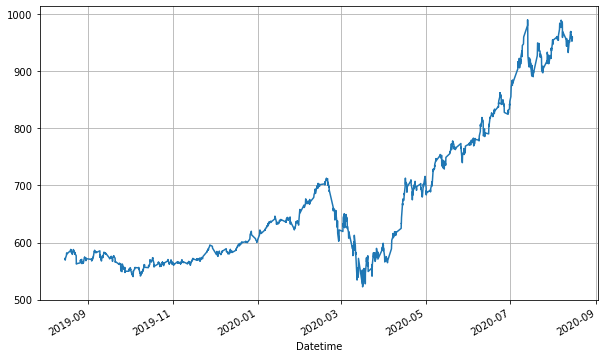

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
propuesta

Datetime
2019-08-15 09:30:00-04:00    572.085034
2019-08-15 10:30:00-04:00    569.805428
2019-08-15 11:30:00-04:00    570.682198
2019-08-15 12:30:00-04:00    570.657449
2019-08-15 13:30:00-04:00    569.810976
                                ...    
2020-08-14 11:30:00-04:00    959.393816
2020-08-14 12:30:00-04:00    960.897393
2020-08-14 13:30:00-04:00    958.303345
2020-08-14 14:30:00-04:00    956.323812
2020-08-14 15:30:00-04:00    959.230063
Length: 1765, dtype: float64

In [23]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

NFLX     0.175234
MELI     0.175234
AMZN     0.152648
EBAY     0.152648
BABA     0.152648
FB       0.094237
GOOGL    0.077882
DIS      0.012461
TWTR     0.007009
Name: MinCVaR, dtype: float64